### Details of the simulated SKA HI data product are the following:

    - 20 square degrees area;

    - 7 arcsec beam size, sampled with 2.8 x 2.8 arcsec pixels;

    - 950–1150 MHz bandwidth, sampled with a 30 kHz resolution. This corresponds to a redshift interval z = 0.235–0.495.

    - noise consistent with a 2000 hour total observation;

    - systematics include imperfect continuum subtraction, simulated RFI flagging and excess noise due to RFI flagging of some of the data.

### These properties are defined in the challenge description, as follows:

1) Source finding, defined as the location in RA (degrees), Dec (degrees) and central frequency (Hz) of the dynamical centre of each source.

2) Source property characterisation, defined as the recovery of the following properties:

    a) Integrated line flux (Jy Hz): the total line flux integrated over the signal $\int F d \nu$

    b) HI size (arcsec): the HI major axis diameter at 1 M⊙ pc-​ 2​.

    c) Line width (km/s): the observed line width at 20 percent of its peak.

    d) Position angle (degrees): the angle of the major axis of the receding side of the galaxy, measured anticlockwise from North.

    e) Inclination angle (degrees): the angle between line-of-sight and a line normal to the plane of the galaxy.

In [1]:
# v=1420/(1+z) MHz
# 1420/(1+0.495),1420/(1+0.235)

In [2]:
# import sys
# sys.path = [i for i in sys.path if 'ska' in i]

In [3]:
import numpy as np
import pylab as plt
import pandas as pd
import seaborn as sns
from astropy.io import fits
from astropy import units as u
from sklearn.metrics import r2_score
from astropy import wcs, coordinates
from matplotlib.colors import LogNorm
from scipy.ndimage import gaussian_filter 
from mpl_toolkits.axes_grid1 import make_axes_locatable



In [4]:
ls ~/scratch/ska/development/

cont_dev.fits   sky_dev.fits               sky_dev_truthcat_v2.txt
README_dev.txt  sky_dev_truthcat_v1.1.txt  sky_dev_v2.fits


### Loading the data, __sky__ is 21cm cube and __cont__ is continuum image and catalogue.

In [5]:
data_path = '/home/vafaeisa/scratch/ska/'

In [6]:
sky = fits.open(data_path+'development/sky_dev_v2.fits')
cont = fits.open(data_path+'development/cont_dev.fits')
sources = pd.read_csv(data_path+'development/sky_dev_truthcat_v2.txt',delimiter=' ')
sources = sources.sort_values('line_flux_integral',ascending=0).reset_index()

columns:
 - 'id' column should list a unique id for each entry in the catalogue.  
 - RA
 - Dec
 - HI size
 - integrated line flux
 - central frequency
 - position angle
 - inclination angle
 - line width



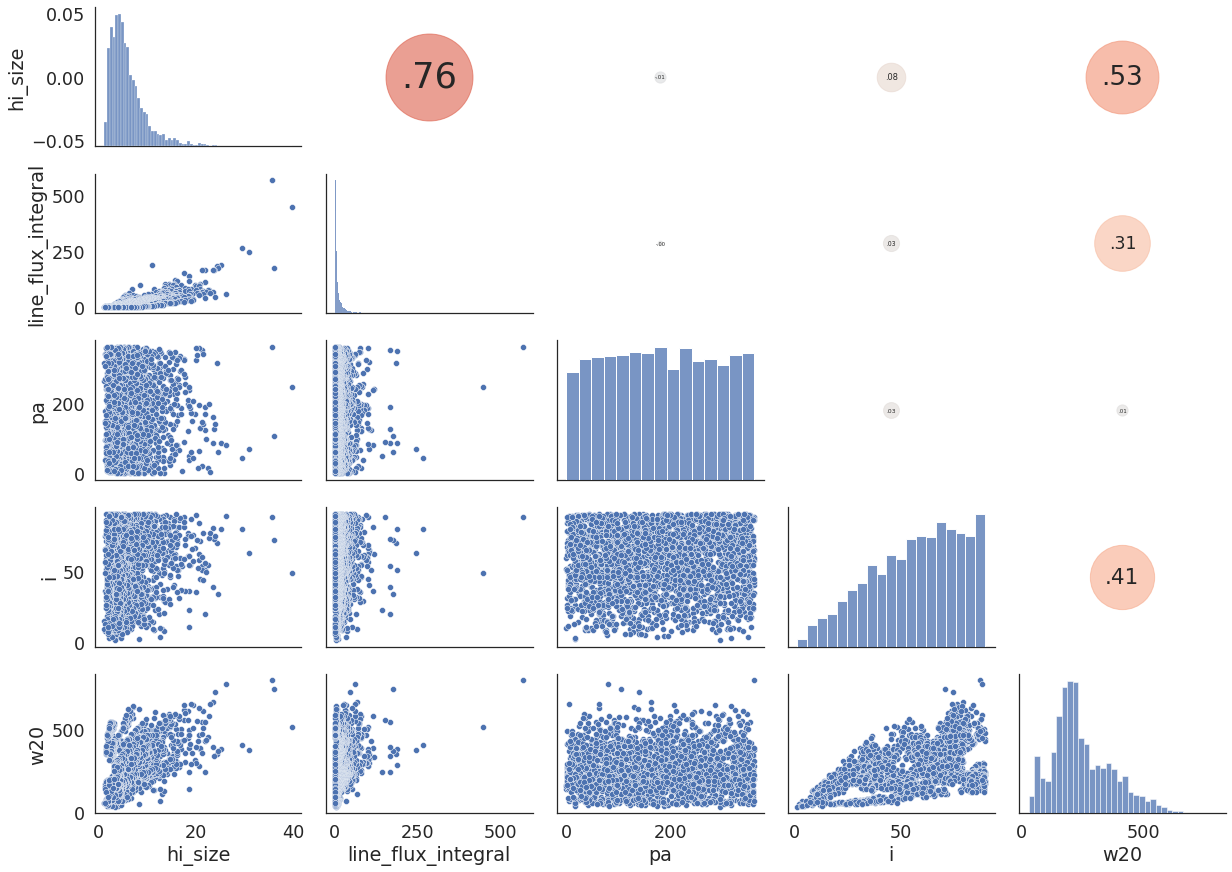

In [7]:
from scipy import stats
def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 10000
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="coolwarm",
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = abs(corr_r) * 40 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)
sns.set(style='white', font_scale=1.6)
g = sns.PairGrid(sources[['hi_size','line_flux_integral','pa','i','w20']], aspect=1.4, diag_sharey=False)
g.map_lower(sns.scatterplot)
g.map_diag(sns.histplot, kde_kws={'color': 'black'})
g.map_upper(corrdot)
plt.tight_layout()

In [8]:
header = sky[0].header

# CRPIX1 = header['CRPIX1']
# CDELT1 = header['CDELT1']
# CRVAL1 = header['CRVAL1']
# CTYPE1 = header['CTYPE1']
# CRPIX2 = header['CRPIX2']
# CDELT2 = header['CDELT2']
# CRVAL2 = header['CRVAL2']
# CTYPE2 = header['CTYPE2']
dfreq = header['CDELT3']
freq0 = header['CRVAL3']

# lx = header['NAXIS1']
# ly = header['NAXIS2']

# # frequency list in the HI cube
nf,nx,ny = sky[0].data.shape
freqs = np.arange(freq0,freq0+nf*dfreq,dfreq)
fqmhz = freqs/1e6

coord_sys = wcs.WCS(header)
ra, dec = sources['ra'],sources['dec']
num_sources = len(ra)
radec_coords = coordinates.SkyCoord(ra=ra, dec=dec, unit='deg', frame='fk5')
coords_ar = np.vstack([radec_coords.ra*u.deg, radec_coords.dec*u.deg,
                         np.zeros(num_sources)]).T
xy_coords = coord_sys.wcs_world2pix(coords_ar, 0)
x_coords, y_coords = xy_coords[:,0], xy_coords[:,1]
f_coordsf = sources['central_freq']

In [10]:
psky = sky[0].data
csky = cont[0].data

# smoothed_sky = gaussian_filter(sky[0].data,sigma=(3,3,5))

In [11]:
flux_inds = np.argsort(sources['line_flux_integral'].values)[::-1]

### Visualization based on pixel

In [12]:
# sources = sources.iloc[:1000]

,index,id,ra,dec,hi_size,line_flux_integral,central_freq,pa,i,w20
1,226,226,179.794891,-29.90855,39.778779,446.57949,1.122020e+09,246.478027,48.21645,513.491308


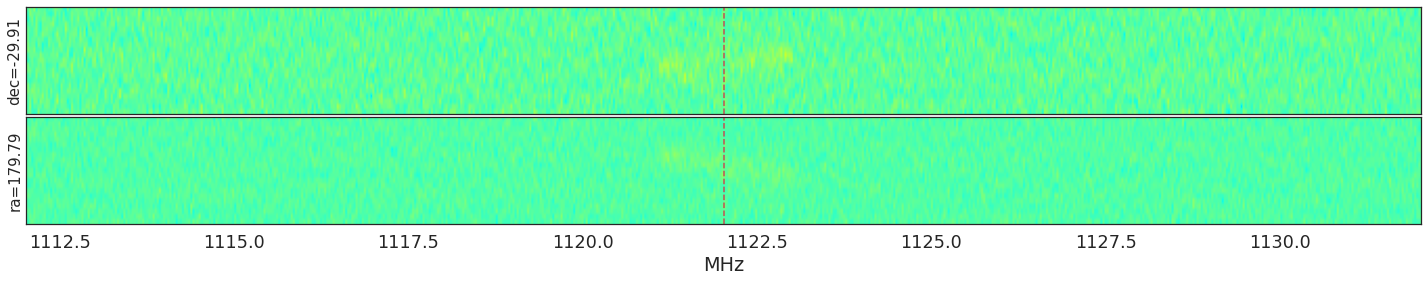

In [15]:
ii = 1

source = sources.loc[flux_inds[ii]:flux_inds[ii],:]

ra_s = source['ra'].values
dec_s = source['dec'].values
freq_s = source['central_freq'].values
his = source['hi_size'].values
ra_p,dec_p,freq_p = coord_sys.wcs_world2pix(np.array([ra_s,dec_s,freq_s]).reshape(1,3),0).T.astype(int)
ra_p,dec_p,freq_p = ra_p[0],dec_p[0],freq_p[0]
# ra_p,dec_p,freq_p

ds = 10
dff = 10

fig,(ax1,ax2) = plt.subplots(2,1,figsize=(25,4))

patch = psky[:,dec_p-ds:dec_p+ds+1,ra_p-ds:ra_p+ds+1]
# patch = gaussian_filter(patch,(2,2,5))
extent = np.array([fqmhz.min(),fqmhz.max(),0,1])
ax1.imshow(np.mean(patch,axis=2).T,aspect='auto',cmap='jet', extent=extent,origin='lower')
ax1.plot(2*[freq_s/1e6],[0,1],'r--')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_ylabel('dec={:2.2f}'.format(dec_s[0]),fontsize=15)
ax1.set_xlim(max(950,freq_s/1e6-dff),min(1150,freq_s/1e6+dff))
ax2.imshow(np.mean(patch,axis=1).T,aspect='auto',cmap='jet', extent=extent,origin='lower')
ax2.plot(2*[freq_s/1e6],[0,1],'r--')
ax2.set_yticks([])
ax2.set_ylabel('ra={:2.2f}'.format(ra_s[0]),fontsize=15)
ax2.set_xlim(max(950,freq_s/1e6-dff),min(1150,freq_s/1e6+dff))

ax2.set_xlabel('MHz')
plt.subplots_adjust(hspace=0.03)

source

(950.0, 1150.0)

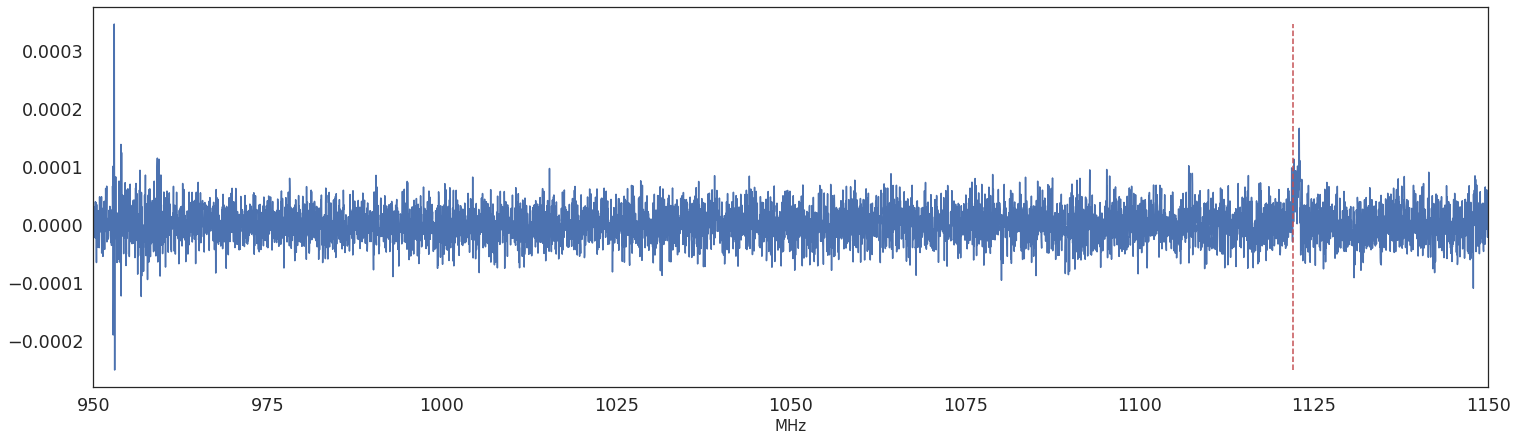

In [16]:
fig,ax = plt.subplots(1,1,figsize=(25,7))

freqs_s = psky[:,dec_p,ra_p]
ax.plot(freqs/1e6,freqs_s)
ax.plot(2*[freq_s/1e6],[freqs_s.min(),freqs_s.max()],'r--')
ax.set_xlabel('MHz',fontsize=15)
ax.set_xlim(950,1150)
# ax.set_xlim(max(950,freq_s/1e6-100),min(1150,freq_s/1e6+100))

(121, 21, 21)


,index,id,ra,dec,hi_size,line_flux_integral,central_freq,pa,i,w20
1,226,226,179.794891,-29.90855,39.778779,446.57949,1.122020e+09,246.478027,48.21645,513.491308


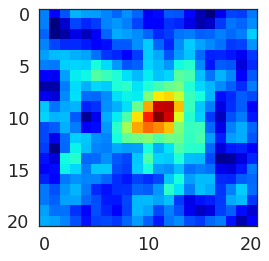

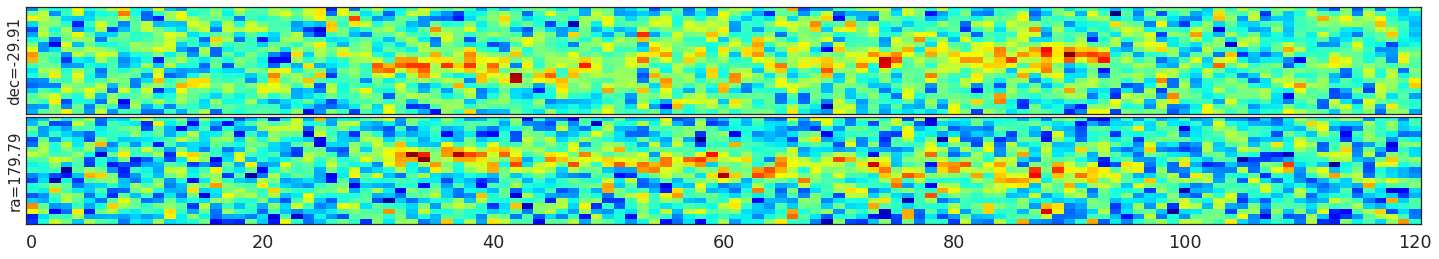

In [21]:
ii = 1

source = sources.loc[flux_inds[ii]:flux_inds[ii],:]

ra_s = source['ra'].values
dec_s = source['dec'].values
freq_s = source['central_freq'].values

ra_p,dec_p,freq_p = coord_sys.wcs_world2pix(np.array([ra_s,dec_s,freq_s]).reshape(1,3),0).T.astype(int)
ra_p,dec_p,freq_p = ra_p[0],dec_p[0],freq_p[0]
# ra_p,dec_p,freq_p

ds = 10
dff = 60

patch = psky[freq_p-dff:freq_p+dff+1,dec_p-ds:dec_p+ds+1,ra_p-ds:ra_p+ds+1]
# patch = gaussian_filter(patch,(2,2,5))
print(patch.shape)

plt.imshow(np.mean(patch,axis=0),cmap='jet')

fig,(ax1,ax2) = plt.subplots(2,1,figsize=(25,4))
ax1.imshow(np.mean(patch,axis=2).T,aspect='auto',cmap='jet', origin='lower')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_ylabel('dec={:2.2f}'.format(dec_s[0]),fontsize=15)

ax2.imshow(np.mean(patch,axis=1).T,aspect='auto',cmap='jet', origin='lower')
ax2.set_yticks([])
ax2.set_ylabel('ra={:2.2f}'.format(ra_s[0]),fontsize=15)

plt.subplots_adjust(hspace=0.03)

source

## Characterization

In [37]:
ds = 10
dff = 50
patches = []
chars = []
for ii in range(sources.shape[0]):
    source = sources.loc[ii,:]
    ra_s = source['ra']
    dec_s = source['dec']
    freq_s = source['central_freq']
    ra_p,dec_p,freq_p = coord_sys.wcs_world2pix(np.array([ra_s,dec_s,freq_s]).reshape(1,3),0).T.astype(int)
    ra_p,dec_p,freq_p = ra_p[0],dec_p[0],freq_p[0]
    patch = psky[freq_p-dff:freq_p+dff+1,dec_p-ds:dec_p+ds+1,ra_p-ds:ra_p+ds+1]
    if patch.shape!=(2*dff+1,2*ds+1,2*ds+1):
        continue
    
    patches.append(patch.T)
    chars.append(sources.loc[ii,['hi_size','line_flux_integral','pa','i','w20']].values)

patches = np.array(patches)
chars = np.array(chars)
ndata,nd1,nd2,nd3 = patches.shape
n_classes = chars.shape[1]
patches.shape,chars.shape

((2580, 21, 21, 101), (2580, 5))

''

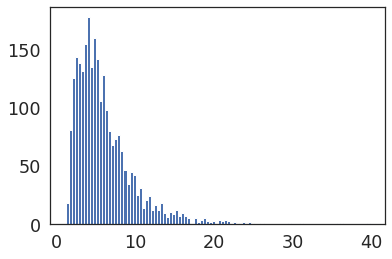

In [38]:
plt.hist(chars[:,0],100)
# plt.xscale('log')
;

In [39]:
chars.shape

(2580, 5)

In [61]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def make_gen(x):
    def gen():
      i = 0
      while(i<len(x)):
        yield next(x)
        i +=1
    return gen

def add_noise(img,sigma=0.01):
    '''Add random noise to an image'''
    deviation = sigma*np.random.uniform(0,1)
    noise = np.random.normal(0, sigma, img.shape)
    img += noise
    np.clip(img, 0., 1.)
    return img

data_gen_args = dict(rotation_range=0,
                     width_shift_range=0.01,
                     height_shift_range=0.01,
                     zoom_range=0.01,
                     horizontal_flip=True,
                     vertical_flip=True,
#                      preprocessing_function=add_noise,
                     fill_mode="nearest")

aug = ImageDataGenerator(**data_gen_args)
# flow = aug.flow(X_train,y_train,batch_size=32,seed=0)
# flow_gen = make_gen(flow)
# dataset = tf.data.Dataset.from_generator(flow_gen,output_types=(tf.float32),output_shapes=(None,nd1,nd2,nd3))


## Classification

[]

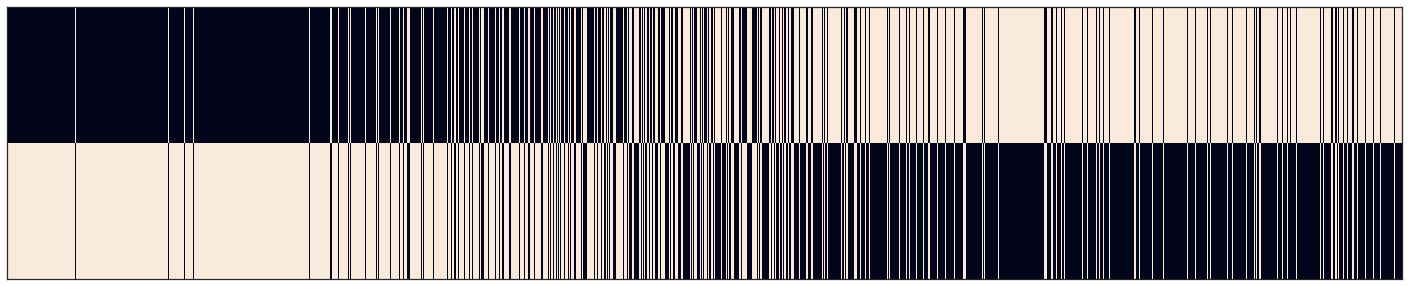

In [82]:
nclass = 2
cls_ch = np.zeros((chars.shape[0],5,nclass))
pbins = np.linspace(0,100,nclass+1)
for i in range(5):
    xx = chars[:,i]
    bins = []
    for j in range(nclass+1):
        bins.append(np.percentile(xx,pbins[j]))
    
    for j in range(nclass):
        filt = (bins[j]<xx) & (xx<bins[j+1])
        cls_ch[filt,i,j] = 1

fig,ax = plt.subplots(figsize=(25,5))
ax.imshow(cls_ch[:,0,:].T,aspect='auto',interpolation='none')
ax.set_xticks([])
ax.set_yticks([])

In [83]:
cls_ch.shape

(2580, 5, 2)

In [75]:
def HighRes3DNetClassifier(input_shape, n_classes=1, activation="relu", l1=1e-10, dropout_rate=0, name="highresnet"):
    """Instantiate HighResNet model."""

    conv_kwds = {"kernel_size": (3, 3, 3), "padding": "same"}
    
    n_repeat = 3
    n_base_filters = 4

    inputs = layers.Input(shape=input_shape)
    x = tf.expand_dims(inputs,-1)
    x = layers.Conv3D(n_base_filters, **conv_kwds)(x)

    for ii in range(n_repeat):
        skip = x
#         x = layers.BatchNormalization()(x)
#         x = layers.Activation(activation)(x)
#         x = layers.Conv3D(n_base_filters, **conv_kwds)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(activation)(x)
        x = layers.Conv3D(n_base_filters, **conv_kwds)(x)
        x = layers.Add()([x, skip])

        x = layers.MaxPooling3D((2, 2, 4))(x)

#     x = ZeroPadding3DChannels(n_base_filters//2)(x)
#     for ii in range(n_repeat):
#         skip = x
#         x = layers.BatchNormalization()(x)
#         x = layers.Activation(activation)(x)
#         x = layers.Conv3D(n_base_filters * 2, dilation_rate=2, **conv_kwds)(x)
#         x = layers.BatchNormalization()(x)
#         x = layers.Activation(activation)(x)
#         x = layers.Conv3D(n_base_filters * 2, dilation_rate=2, **conv_kwds)(x)
#         x = layers.Add()([x, skip])
        
# #         x = layers.MaxPooling2D((2, 2))(x)

#     x = ZeroPadding3DChannels(n_base_filters)(x)
#     for ii in range(n_repeat):
#         skip = x
#         x = layers.BatchNormalization()(x)
#         x = layers.Activation(activation)(x)
#         x = layers.Conv3D(n_base_filters * 4, dilation_rate=4, **conv_kwds)(x)
#         x = layers.BatchNormalization()(x)
#         x = layers.Activation(activation)(x)
#         x = layers.Conv3D(n_base_filters * 4, dilation_rate=4, **conv_kwds)(x)
#         x = layers.Add()([x, skip])
        
#         x = layers.MaxPooling2D((2, 2))(x)


    sh = x.shape[1:]
#     print(sh)
    x = layers.Flatten()(x)

#     x = layers.Dense(np.prod(sh)//2, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(n_classes, activation="linear")(x)

#     x = layers.Conv3D(filters=n_classes, kernel_size=(1, 1, 1), padding="same")(x)

#     final_activation = "sigmoid" if n_classes == 1 else "softmax"
#     final_activation = "relu"
#     x = layers.Activation(final_activation)(x)
#     x = tf.squeeze(x,-1)
    
#     x = layers.Flatten()(x)

#     x = layers.Dense(n_latent, activation="relu")(x)
#     x = layers.Dropout(0.6)(x)
#     out = layers.Dense(n_class, activation="softmax",activity_regularizer=regularizers.l1(l1))(x)


    # QUESTION: where should dropout go?
    model = keras.Model(inputs=inputs, outputs=x, name=name) 

    model.compile(
    #     loss=keras.losses.BinaryCrossentropy(),
        loss=keras.losses.CategoricalCrossentropy(),
        optimizer='adam',
        metrics=["accuracy"],
    )
    return model

In [96]:
batch_size=32

ii = 4
X_train, X_test, y_train, y_test = train_test_split(patches,cls_ch[:,ii,:], test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

flow = aug.flow(X_train,y_train,batch_size=32,seed=0)

(2064, 21, 21, 101) (516, 21, 21, 101) (2064, 2) (516, 2)


In [97]:
model = HighRes3DNetClassifier(input_shape=(nd1,nd2,nd3), n_classes=nclass)
model.summary(line_length=120,positions=[.33, .55, .67, 1.])

Model: "highresnet"
________________________________________________________________________________________________________________________
Layer (type)                           Output Shape               Param #       Connected to                            
input_10 (InputLayer)                  [(None, 21, 21, 101)]      0                                                     
________________________________________________________________________________________________________________________
tf.expand_dims_9 (TFOpLambda)          (None, 21, 21, 101, 1)     0             input_10[0][0]                          
________________________________________________________________________________________________________________________
conv3d_36 (Conv3D)                     (None, 21, 21, 101, 4)     112           tf.expand_dims_9[0][0]                  
________________________________________________________________________________________________________________________
batch_normal

In [98]:
history = model.fit(flow,
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    epochs=100,
                    verbose=1)

Epoch 1/100
64/64 [==============================] - 12s 168ms/step - loss: 5.5521 - accuracy: 0.4879
Epoch 2/100
64/64 [==============================] - 11s 170ms/step - loss: 1.2117 - accuracy: 0.5087
Epoch 3/100
64/64 [==============================] - 11s 168ms/step - loss: 0.9780 - accuracy: 0.5044
Epoch 4/100
64/64 [==============================] - 11s 168ms/step - loss: 0.9981 - accuracy: 0.5199
Epoch 5/100
64/64 [==============================] - 11s 168ms/step - loss: 0.9458 - accuracy: 0.5377
Epoch 6/100
64/64 [==============================] - 11s 168ms/step - loss: 1.1050 - accuracy: 0.5248
Epoch 7/100
64/64 [==============================] - 11s 168ms/step - loss: 0.8873 - accuracy: 0.5122
Epoch 8/100
64/64 [==============================] - 11s 169ms/step - loss: 0.7489 - accuracy: 0.4841
Epoch 9/100
64/64 [==============================] - 11s 167ms/step - loss: 0.7333 - accuracy: 0.5125
Epoch 10/100
64/64 [==============================] - 11s 169ms/step - loss: 0.739

## Regression

In [62]:
# mins = 
means = np.mean(chars,axis=0,keepdims=1)
stds = np.std(chars,axis=0,keepdims=1)

chars_norm = chars-means
chars_norm = chars_norm/stds


mins = np.min(chars,axis=0,keepdims=1)
maxs = np.max(chars,axis=0,keepdims=1)

chars_norm = chars-mins
chars_norm = chars_norm/(maxs-mins)
# chars.shape
chars_norm = chars_norm.astype(np.float32)

In [63]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(patches,chars_norm, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

flow = aug.flow(X_train,y_train,batch_size=32,seed=0)

/home/vafaeisa/miniconda3/envs/gpu1/lib/python3.9/site-packages/keras_preprocessing/image/numpy_array_iterator.py:129: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (2064, 21, 21, 101) (101 channels).
  warnings.warn('NumpyArrayIterator is set to use the '


(32, 21, 21, 101) (32, 5)


(-0.5, 20.5, 20.5, -0.5)

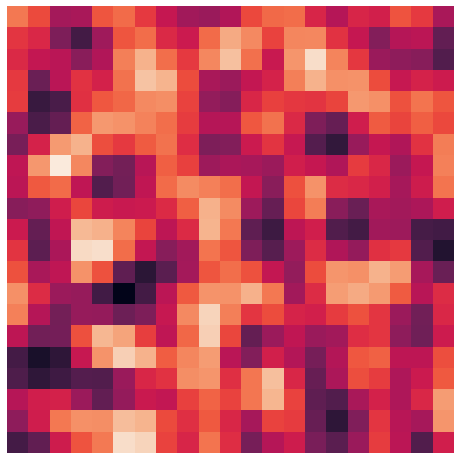

In [64]:
# xample,yample = dataset.batch(10)

for e1,e2 in flow:
    print(e1.shape,e2.shape)
    break

fig,ax = plt.subplots(1,1,figsize=(8,3*nd3))

i = np.random.randint(e1.shape[0])
ax.imshow(e1[i,:,:,:].mean(axis=-1))
ax.axis('off')
ax.axis('off')

In [108]:
# data_gen_args = dict(rotation_range=10,
#                      width_shift_range=0.1,
#                      height_shift_range=0.1,
#                      zoom_range=0.05,
#                      horizontal_flip=True,
#                      vertical_flip=True,
#                      preprocessing_function=add_noise,
#                      fill_mode="nearest")

# aug1 = ImageDataGenerator(**data_gen_args)
# aug2 = ImageDataGenerator(**data_gen_args)

# nac = nac_data_set[dname]
# mac = mac_data_set[dname]

# nac_flow = aug1.flow(nac,batch_size=BS,seed=seed)
# mac_flow = aug2.flow(mac,batch_size=BS,seed=seed)
# gen_nac = make_gen(nac_flow)
# gen_mac = make_gen(mac_flow)
# dataset1 = tf.data.Dataset.from_generator(gen_nac,output_types=(tf.float32),output_shapes=(None,nd1,nd2,nd3))
# dataset2 = tf.data.Dataset.from_generator(gen_mac,output_types=(tf.float32),output_shapes=(None,nd1,nd2,nd3))
# dataset3 = tf.data.Dataset.zip((dataset1, dataset2))#.batch(10)

# federated_train_data.append(dataset3)

In [109]:
# class ZeroPadding3DChannels(layers.Layer):
#     """Pad the last dimension of a 5D tensor symmetrically with zeros.
#     This is meant for 3D convolutions, where tensors are 5D.
#     """

#     def __init__(self, padding, **kwds):
#         self.padding = padding
#         # batch, x, y, z, channels
#         self._paddings = [[0, 0], [0, 0], [0, 0], [0, 0], [self.padding, self.padding]]
#         super(ZeroPadding3DChannels, self).__init__(**kwds)

#     def call(self, x):
#         return tf.pad(x, paddings=self._paddings, mode='CONSTANT', constant_values=0)
    
#     def get_config(self):
#         config = super().get_config().copy()
#         config.update({
#             'padding': self.padding 
#         })
#         return config

# def HighRes3DNet(input_shape, n_classes=1, activation="relu", dropout_rate=0, name="highresnet"):
#     """Instantiate HighResNet model."""

#     conv_kwds = {"kernel_size": (3, 3, 3), "padding": "same"}
    
#     n_repeat = 1
#     n_base_filters = 4

#     inputs = layers.Input(shape=input_shape)
#     x = tf.expand_dims(inputs,-1)
#     x = layers.Conv3D(n_base_filters, **conv_kwds)(x)

#     for ii in range(n_repeat):
#         skip = x
#         x = layers.BatchNormalization()(x)
#         x = layers.Activation(activation)(x)
#         x = layers.Conv3D(n_base_filters, **conv_kwds)(x)
#         x = layers.BatchNormalization()(x)
#         x = layers.Activation(activation)(x)
#         x = layers.Conv3D(n_base_filters, **conv_kwds)(x)
#         x = layers.Add()([x, skip])
        
# #         x = layers.MaxPooling2D((2, 2))(x)

#     x = ZeroPadding3DChannels(n_base_filters//2)(x)
#     for ii in range(n_repeat):
#         skip = x
#         x = layers.BatchNormalization()(x)
#         x = layers.Activation(activation)(x)
#         x = layers.Conv3D(n_base_filters * 2, dilation_rate=2, **conv_kwds)(x)
#         x = layers.BatchNormalization()(x)
#         x = layers.Activation(activation)(x)
#         x = layers.Conv3D(n_base_filters * 2, dilation_rate=2, **conv_kwds)(x)
#         x = layers.Add()([x, skip])
        
# #         x = layers.MaxPooling2D((2, 2))(x)

#     x = ZeroPadding3DChannels(n_base_filters)(x)
#     for ii in range(n_repeat):
#         skip = x
#         x = layers.BatchNormalization()(x)
#         x = layers.Activation(activation)(x)
#         x = layers.Conv3D(n_base_filters * 4, dilation_rate=4, **conv_kwds)(x)
#         x = layers.BatchNormalization()(x)
#         x = layers.Activation(activation)(x)
#         x = layers.Conv3D(n_base_filters * 4, dilation_rate=4, **conv_kwds)(x)
#         x = layers.Add()([x, skip])
        
# #         x = layers.MaxPooling2D((2, 2))(x)

#     x = layers.Conv3D(filters=n_classes, kernel_size=(1, 1, 1), padding="same")(x)

# #     final_activation = "sigmoid" if n_classes == 1 else "softmax"
#     final_activation = "relu"
#     x = layers.Activation(final_activation)(x)
#     x = tf.squeeze(x,-1)
    
# #     x = layers.Flatten()(x)

# #     x = layers.Dense(n_latent, activation="relu")(x)
# #     x = layers.Dropout(0.6)(x)
# #     out = layers.Dense(n_class, activation="softmax",activity_regularizer=regularizers.l1(l1))(x)


#     # QUESTION: where should dropout go?

#     return tf.keras.Model(inputs=inputs, outputs=x, name=name) 

# model0 = HighRes3DNet(input_shape=(nd1,nd2,nd3))
# model0.summary(line_length=120,positions=[.33, .55, .67, 1.])

In [110]:
class ZeroPadding3DChannels(layers.Layer):
    """Pad the last dimension of a 5D tensor symmetrically with zeros.
    This is meant for 3D convolutions, where tensors are 5D.
    """

    def __init__(self, padding, **kwds):
        self.padding = padding
        # batch, x, y, z, channels
        self._paddings = [[0, 0], [0, 0], [0, 0], [0, 0], [self.padding, self.padding]]
        super(ZeroPadding3DChannels, self).__init__(**kwds)

    def call(self, x):
        return tf.pad(x, paddings=self._paddings, mode='CONSTANT', constant_values=0)
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'padding': self.padding 
        })
        return config

def HighRes3DNetRegressor(input_shape, n_classes=1, activation="relu", l1=1e-10, dropout_rate=0, name="highresnet"):
    """Instantiate HighResNet model."""

    conv_kwds = {"kernel_size": (3, 3, 3), "padding": "same"}
    
    n_repeat = 3
    n_base_filters = 4

    inputs = layers.Input(shape=input_shape)
    x = tf.expand_dims(inputs,-1)
    x = layers.Conv3D(n_base_filters, **conv_kwds)(x)

    for ii in range(n_repeat):
        skip = x
#         x = layers.BatchNormalization()(x)
#         x = layers.Activation(activation)(x)
#         x = layers.Conv3D(n_base_filters, **conv_kwds)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(activation)(x)
        x = layers.Conv3D(n_base_filters, **conv_kwds)(x)
        x = layers.Add()([x, skip])

        x = layers.MaxPooling3D((2, 2, 4))(x)

#     x = ZeroPadding3DChannels(n_base_filters//2)(x)
#     for ii in range(n_repeat):
#         skip = x
#         x = layers.BatchNormalization()(x)
#         x = layers.Activation(activation)(x)
#         x = layers.Conv3D(n_base_filters * 2, dilation_rate=2, **conv_kwds)(x)
#         x = layers.BatchNormalization()(x)
#         x = layers.Activation(activation)(x)
#         x = layers.Conv3D(n_base_filters * 2, dilation_rate=2, **conv_kwds)(x)
#         x = layers.Add()([x, skip])
        
# #         x = layers.MaxPooling2D((2, 2))(x)

#     x = ZeroPadding3DChannels(n_base_filters)(x)
#     for ii in range(n_repeat):
#         skip = x
#         x = layers.BatchNormalization()(x)
#         x = layers.Activation(activation)(x)
#         x = layers.Conv3D(n_base_filters * 4, dilation_rate=4, **conv_kwds)(x)
#         x = layers.BatchNormalization()(x)
#         x = layers.Activation(activation)(x)
#         x = layers.Conv3D(n_base_filters * 4, dilation_rate=4, **conv_kwds)(x)
#         x = layers.Add()([x, skip])
        
#         x = layers.MaxPooling2D((2, 2))(x)


    sh = x.shape[1:]
#     print(sh)
    x = layers.Flatten()(x)

    x = layers.Dense(np.prod(sh)//2, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(n_classes, activation="linear")(x)

#     x = layers.Conv3D(filters=n_classes, kernel_size=(1, 1, 1), padding="same")(x)

#     final_activation = "sigmoid" if n_classes == 1 else "softmax"
#     final_activation = "relu"
#     x = layers.Activation(final_activation)(x)
#     x = tf.squeeze(x,-1)
    
#     x = layers.Flatten()(x)

#     x = layers.Dense(n_latent, activation="relu")(x)
#     x = layers.Dropout(0.6)(x)
#     out = layers.Dense(n_class, activation="softmax",activity_regularizer=regularizers.l1(l1))(x)


    # QUESTION: where should dropout go?
    model = keras.Model(inputs=inputs, outputs=x, name=name) 

    model.compile(
    #     loss=keras.losses.BinaryCrossentropy(),
        loss=keras.losses.MeanSquaredError(),
        optimizer='adam',
        metrics=["accuracy"],
    )
    return model

# model0 = HighRes3DNetClassifier(input_shape=(nd1,nd2,nd3), n_classes=n_classes)
# model0.summary(line_length=120,positions=[.33, .55, .67, 1.])

In [111]:
# X_train, X_test, y_train, y_test = train_test_split(patches,chars_norm, test_size=0.2, random_state=42)

# plt.hist(np.log(y_train[:,1]+1e-3))

In [112]:
models = []
fluxmins = []
# topw = np.array([500,700,1000,1500,2000,y_train.shape[0]])
topw = np.array([y_train.shape[0]])

for i in range(len(topw)):
#     filt = trsh<np.log(y_train[:,1]+1e-5)
#     flux = y_train[:,1]
#     inds = np.argsort(flux)[::-1]
#     inds = inds[:topw[i]]
#     fluxmin = np.min(y_train[inds,1])
#     print(i,fluxmin)
#     fluxmins.append(fluxmin)
    data_gen_args = dict(rotation_range=10,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         zoom_range=0.05,
                         horizontal_flip=True,
                         vertical_flip=True,
                         preprocessing_function=add_noise,
                         fill_mode="nearest")

    aug = ImageDataGenerator(**data_gen_args)
    print(X_train[inds].shape,y_train[inds].shape)
    flow = aug.flow(X_train[inds],y_train[inds],batch_size=32,seed=0)
    batch_size = 32
    
    model = HighRes3DNetClassifier(input_shape=(nd1,nd2,nd3), n_classes=n_classes)
    history = model.fit(flow,
                        steps_per_epoch=X_train[inds].shape[0] // batch_size,
                        epochs=150,
                        verbose=0)
    
    models.append(model)

(773, 21, 21, 121) (773, 1)


In [113]:
# # for i,fluxmin in enumerate(fluxmins):
# #     filt1 = fluxmin<y_train[:,1]
# #     filt = fluxmin<y_test[:,1]
# #     print(filt1.sum(),filt.sum())



# r2s = []

# for i,fluxmin in enumerate(fluxmins):
# #     filt = fluxmin<y_test[:,1]
#     data_gen_args = dict(rotation_range=10,
#                          width_shift_range=0.1,
#                          height_shift_range=0.1,
#                          zoom_range=0.05,
#                          horizontal_flip=True,
#                          vertical_flip=True,
#                          preprocessing_function=add_noise,
#                          fill_mode="nearest")

# #     aug = ImageDataGenerator(**data_gen_args)
# #     flow = aug.flow(X_test[filt],y_test[filt],batch_size=32,seed=0)
# #     batch_size = 32

#     model = models[i]
    
#     y_pred = model.predict(X_test)
#     rp = []
#     for j in range(n_classes): 
#         rp.append(r2_score(y_test[:,j],y_pred[:,j]))
#     r2s.append(rp)
# r2s = np.array(r2s)
# print(r2s)

In [114]:
data_gen_args = dict(rotation_range=10,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.05,
                     horizontal_flip=True,
                     vertical_flip=True,
                     preprocessing_function=add_noise,
                     fill_mode="nearest")

#     aug = ImageDataGenerator(**data_gen_args)
#     flow = aug.flow(X_test[filt],y_test[filt],batch_size=32,seed=0)
#     batch_size = 32

model = models[0]

y_pred = model.predict(X_test)
rp = []
for j in range(n_classes): 
    print(r2_score(y_test[:,j],y_pred[:,j]))

-0.012581847198845253


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

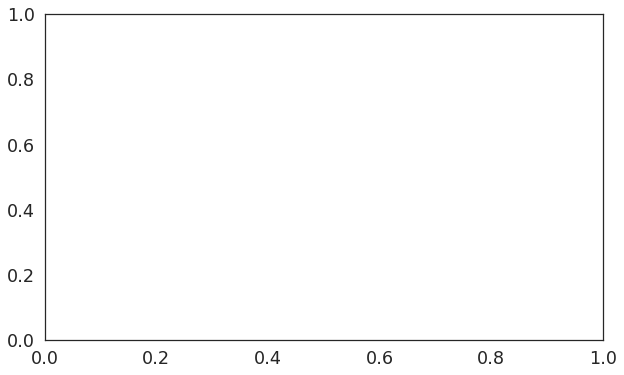

In [63]:
lbls = ['hi_size','line_flux_integral','pa','i','w20']

fig,ax = plt.subplots(1,1,figsize=(10,6))

for i in range(n_classes):
    ax.plot(fluxmins,r2s[:,i],label=lbls[i])
    
ax.set_ylim(-2,1)
ax.legend(loc=(1,0.6))

(array([ 9., 27., 56., 62., 31.,  7.,  0.,  0.,  1.,  1.]),
 array([0.62516844, 0.6251741 , 0.62517977, 0.62518543, 0.6251911 ,
        0.6251967 , 0.62520236, 0.625208  , 0.6252137 , 0.62521935,
        0.625225  ], dtype=float32),
 <BarContainer object of 10 artists>)

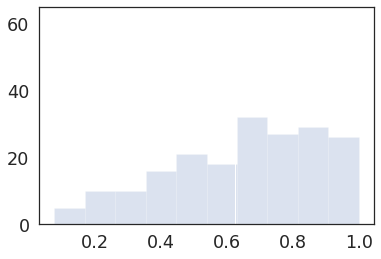

In [39]:
j = 3

plt.hist(y_test[:,j],color='b',alpha=0.2)
plt.hist(y_pred[:,j],color='r')

In [40]:
# y_pred[:,j]

In [41]:
1

1

In [42]:
def build_model_2dconv(shape, n_class, n_latent=64, n_layers=1, kernel_size=3, pooling_size=2, l1=1e-10):

    
    inp = keras.Input(shape=shape, name="input")

    x = layers.Conv2D(16, (kernel_size, kernel_size), activation='relu', padding='same', activity_regularizer=regularizers.l1(l1))(inp)
    x = layers.MaxPooling2D((pooling_size, pooling_size), padding='same')(x)
    
    for _ in range(n_layers):
        x = layers.Conv2D(8, (kernel_size, kernel_size), activation='relu', padding='same', activity_regularizer=regularizers.l1(l1))(x)
        x = layers.MaxPooling2D((pooling_size, pooling_size), padding='same')(x)

    sh = x.shape[1:]
#     print(sh)
    x = layers.Flatten()(x)

    latent = layers.Dense(n_latent, activation="relu")(x)
    dop = layers.Dropout(0.6)(latent)
    out = layers.Dense(n_class, activation="softmax",activity_regularizer=regularizers.l1(l1))(dop)

#     x = layers.Dense(2, activation='softmax',
#                 activity_regularizer=regularizers.l1(l1))(x)
    
    
    
    
    
#     inp = keras.Input(shape=shape, name="input")
#     x = layers.Dense(128, activation="relu")(inp)
#     latent = layers.Dense(n_latent, activation="relu")(x)
#     dop = layers.Dropout(0.6)(latent)
#     out = layers.Dense(n_class, activation="softmax")(dop)
#     # out = layers.Dense(n_class, activation="sigmoid")(dop)


    clf = keras.Model(inputs=inp, outputs=out, name="Classifier")
    drt = keras.Model(inputs=inp, outputs=latent, name="DimensionalityReducer")

#     clf.summary()

    clf.compile(
    #     loss=keras.losses.BinaryCrossentropy(),
        loss=keras.losses.CategoricalCrossentropy(),
        optimizer='adam',
        metrics=["accuracy"],
    )
    return clf,drt